# See outline for text/story

# Part 0: Preprocessing

In [2]:
## Import required packages, global parameters

%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
from scipy import signal
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as xccrs
import cartopy.feature as cfeature
# import xesmf as xe
%matplotlib inline
import momlevel
import datetime as dt
import xeofs
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from mypyutils import colormap_utils as mycolors
mdates.MonthLocator(bymonthday=15)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": 'serif',
    "font.serif": 'Computer Modern'
})    

cols=['k','C1','C0','C2','C3','C4','C5','C6']   
panellabs=list(map(chr, range(97, 112)))
# panellabs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def detrend_df(df):

    df_det=df.copy()
    days = pd.to_datetime(df.index).map(dt.datetime.toordinal)
    trend=[]
    
    for column in df:
        y=df[column]
        not_nan_ind = ~np.isnan(y)
        coefficients = np.polyfit(days[not_nan_ind],y[not_nan_ind],1)    
        fit=np.polyval(coefficients,days)
        df_det[column]=df[column]-fit
        trend.append(coefficients[0])
    return df_det, np.array(trend)*365.25*10

## tg processing 1950-2021

In [13]:
## reading in TGs from PSMSL csvs (processing script elsewhere), converting to pandas dataframes

df_ids = pd.read_csv('./PSMSL_ids.csv')
df_ids=df_ids.T
df_ids.index.names = ["name"]
df_ids.rename(columns={0: 'lat', 1: 'lon', 2: 'name2', 3: 'coast'}, inplace = True)
df_ids['coast']=df_ids['coast'].str.zfill(3)
df_ids.coast=df_ids.coast.astype(float)
df_ids.lat=df_ids.lat.astype(float)
df_ids.lon=df_ids.lon.astype(float)
df_ids=df_ids.sort_values(['lat'],axis=0,ascending=[True])
df_ids.lon=(df_ids.lon+360) % 360

df = pd.read_csv('./PSMSL_data.csv')
df.columns,df_ids.columns
df.rename(columns = {'0':'datetime'}, inplace = True)
df['datetime']=pd.to_datetime(df.datetime-719529,unit='D').round('s')
df_ts=df
df_ts.set_index('datetime', inplace=True)

#time bounds of analysis
df_ts=df_ts.loc['1958-01-01':'2022-1-1'] 
df_ts=(df_ts-df_ts.mean(axis=0))/10 #mm->cm

In [14]:
## lat/lon range filtering
w=260; e=293; s=22; n=45; 
# w=278.4; e=295; s=22; n=45; 

mask1 = df_ids['lat'] < n
mask2 = df_ids['lat'] > s
mask3 = df_ids['lon'] > w
mask4 = df_ids['lon'] < e
# mask5 = (df_ids['coast']) < 900
mask=mask1*mask2*mask3*mask4#*mask5#*mask6 #small subset
df_ids=df_ids[mask]
df_ids=df_ids.reset_index()
df_ts = df_ts[df_ids.name]
len(df_ts.T) #number of tgs in region

126

In [35]:
missingmonths = df_ts.isna().sum()
fraccomplete = 1-(missingmonths/len(df_ts))
mask0=(df_ids.lat<35).values*(fraccomplete > .95).values #south of hatteras
mask1=(df_ids.lat>35).values*(fraccomplete > .95).values #north of hatteras
mask2=(mask0+mask1)>0
mask3=~df_ids.name.isin(['497','112','526','636','148','360','135','412','224','429','430','183']).values #upriver north of hatteras
# mask4=~df_ids.name.isin(['497','161','526','1193','520']).values #remove GoM

# mask1 = df_ts['1977-1-1':'1978-1-1'].isna().sum()<12 #data in first year
mask=mask2*mask3#*mask4
tg_ts_filt = df_ts.loc[:,mask]
tgs_in=df_ids
tgs_in.index=tgs_in.name
tgs_in=tgs_in[mask]
missingmonths=missingmonths[mask]

tgnames=tgs_in['name2'].str.replace(r"\(.*\)","").str.replace(r"\,.*","").str.replace(r"\-.*","").str.replace(r"\/.*","").str.title()
tgnames
shortname=tgnames.str.split('(').str[0]
shortname=shortname.str.split(',').str[0]
# shortname['t2']=shortname['t2'].values
shortname

name
188          Key West
520    St. Petersburg
161      Galveston Ii
246         Pensacola
395      Fort Pulaski
234      Charleston I
396        Wilmington
299     Sewells Point
366        Sandy Hook
12          New York 
351           Newport
235            Boston
Name: name2, dtype: object

In [36]:
# interpolate
maxgap=3
tg_demean=tg_ts_filt-tg_ts_filt.mean()
# tg_ibcorr_gmrem=tg_ibcorr-gmsl_df
tg_det,tg_trend = detrend_df(tg_demean)
tg_sea=tg_det.groupby(tg_det.index.month).transform(lambda x: x.mean())
tg_desea=tg_demean-tg_sea
tg_interp=tg_desea.interpolate(axis=0,limit=maxgap, limit_direction='both')
tg_interp=tg_interp+tg_sea

In [37]:
tg_ann=tg_interp.resample("Y").agg(pd.Series.mean, skipna=False)
# tg_ann

/glade/derecho/scratch/clittle/tmp/ipykernel_111915/1629099537.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  tg_ann=tg_interp.resample("Y").agg(pd.Series.mean, skipna=False)


/glade/derecho/scratch/clittle/tmp/ipykernel_111915/704834879.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = shortname[np.arange(0, len(tgnames), ylabspacing)]


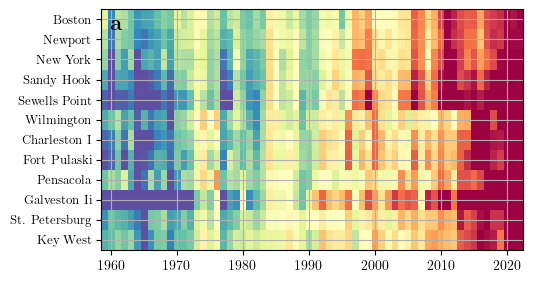

In [38]:
##TG corrections plot
fig = plt.figure(figsize=(14,10))#, tight_layout=True)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

nsim=1
cmap = mycolors.blue2red_cmap(20)
cmap='Spectral_r'
ylabspacing = 1

vmin = -12
vmax2 = -vmin
nsim=0

ax1 = plt.subplot2grid((3,5), (nsim, 1), colspan=2, rowspan=1)

filled1 = ax1.pcolormesh(
    tg_ann.index,
    np.arange(0, len(tgnames), 1),
    tg_ann.T,
    vmin=vmin,
    vmax=vmax2,
    cmap=cmap,
    shading="nearest",
)
plt.figtext(0.02, .9, r"$\bf{" + panellabs[nsim] + '' "}$" , horizontalalignment='left', 
                verticalalignment='bottom', fontsize=16, transform=ax1.transAxes)
# ticks = np.arange(1.5, len(tgnames)+.5, ylabspacing)
# labels = tgnames[np.arange(1, len(tgnames), ylabspacing)]
# ax2.yaxis.set_ticks(ticks, labels=labels)    # plt.xlim([1000,1060])
ticks = np.arange(0, len(tgnames), ylabspacing)
if nsim<5:
    labels = shortname[np.arange(0, len(tgnames), ylabspacing)]
else:
    labels = []
ax1.yaxis.set_ticks(ticks, labels=labels, fontsize=9)
plt.ylim([-.5, len(tgnames)-.5])
plt.grid()
pos = ax1.get_position()  # get the original position

if nsim>1:
    cbar_ax = fig.add_axes(
        [pos.x0, pos.y0-(pos.y1 - pos.y0)/4, (pos.x1-pos.x0), (pos.y1 - pos.y0)/20]
    )
    cbar = fig.colorbar(filled1, orientation="horizontal", cax=cbar_ax, extend="both",ticklocation='bottom')
    cbar.ax.set_title("Sea level anomaly (cm)", rotation=0, size=10, weight="bold")
    cbar.ax.tick_params(labelsize=10)

In [39]:
# tg_interp

## IB-correct filtered TG's using ERA5 surface P

In [40]:
datadir = '/glade/campaign/collections/rda/data/d633005/e5p.moda.an.sfc/'
years=np.arange(1958,1979,1)
datasets = []
for Y in years:
    pic = xr.open_mfdataset(datadir+(str(Y))+'/e5p.moda.an.sfc.128_134_sp.ll025sc.'+(str(Y))+'*.nc')
    datasets.append(pic)
era5be = xr.concat(datasets, dim='time')

In [41]:
datadir = '/glade/campaign/collections/rda/data/d633001/e5.moda.an.sfc/'

years=np.arange(1979,2022,1)
datasets = []
for Y in years:
    # print(Y)
    pic = xr.open_mfdataset(datadir+(str(Y))+'/e5.moda.an.sfc.128_134_sp.ll025sc.'+(str(Y))+'*.nc')
    datasets.append(pic)
era5 = xr.concat(datasets, dim='time')
era5 = xr.concat([era5be, era5], dim='time')
era5 = era5.groupby('time.year').mean('time').rename({'year':'time'})
era5.load()

<xarray.Dataset> Size: 266MB
Dimensions:    (time: 64, latitude: 721, longitude: 1440)
Coordinates:
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) int64 512B 1958 1959 1960 1961 ... 2018 2019 2020 2021
Data variables:
    SP         (time, latitude, longitude) float32 266MB 1.017e+05 ... 6.842e+04
    utc_date   (time) float64 512B 1.958e+09 1.959e+09 ... 2.02e+09 2.021e+09
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB 1 data to netC...
    NETCDF_VERSION:       4.8.1
    CONVERSION_PLATFORM:  Linux r1i2n22 4.12.14-95.51-default #1 SMP Fri Apr ...
    CONVERSION_DATE:      Wed Mar  2 04:23:41 MST 2022
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Wed Mar  2 04:23:43 2022: ncks -4 --ppc default=7 e...
    NCO:                  netCDF Operators version 4.9.5 (Homepage = http://n...

In [42]:
#extract closest pts to TGs
def extract_point(arr, row):
    """Function to extract point from an array
    This function takes an individual row from the output of
    util.geolocate_points and used the information to extract
    that location from the array.
    Parameters
    ----------
    arr : xarray.core.dataarray.DataArray
        Input data array
    row : pandas.core.series.Series
        Row from DataFrame of mapped locations. This row must
        include `name`, `dims`, and `dim_vals`
    Returns
    -------
    xarray.core.dataarray.DataArray
    """
    return xr.DataArray(
        arr.sel(**dict(zip(row["dims"], row["dim_vals"]))),
        name=row["name"],
        attrs={**arr.attrs, **dict(row)},
    ).reset_coords(drop=True)

_xcoord = era5.longitude
_ycoord = era5.latitude

if len(_xcoord.shape) == 1:
       _xcoord, _ycoord = momlevel.tidegauge.tile_nominal_coords(_xcoord, _ycoord)

#     # Check that dimensions are the same for x/y coords
_xdims = tuple(_xcoord.dims)
_ydims = tuple(_xcoord.dims)
assert _xdims == _ydims

    # Make sure mask does not have missing values
mask = xr.ones_like(_xcoord)
if mask.name != "mask":
    mask = mask.rename("mask")

    # Create pandas.DataFrame of model coordinate info
df_model = pd.concat(
    [
        _xcoord.to_dataframe(),
        _ycoord.to_dataframe(),
        mask.to_dataframe(),
    ],
    axis=1,
)

df_mapped = momlevel.tidegauge.geolocate_points(
    df_model, tgs_in, model_coords=(_ycoord.name, _xcoord.name) 
    )
df_mapped["dims"] = [_xdims] * len(df_mapped)

results = xr.Dataset(
        {row["name"]: extract_point(era5.SP, row) for index, row in df_mapped.iterrows()}
    )
results_df=results.to_dataframe()
results_df.columns = results_df.columns.astype(str)
results_df['time']=tg_ann.index
results_df.set_index('time', inplace=True)

/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/momlevel/util.py:514: UserWarning: Constructing coordinates from 1-D vectors. Make sure this is the intended behavior. Do not use `xh`/`yh` when `geolon`/`geolat` are available
  warnings.warn(


In [43]:
#IB removal
tg_ib=-9.948*(results_df/100-1013.3)
tg_ib=(tg_ib-tg_ib.mean(axis=0))/10
tg_ibcorr=tg_ann-tg_ib

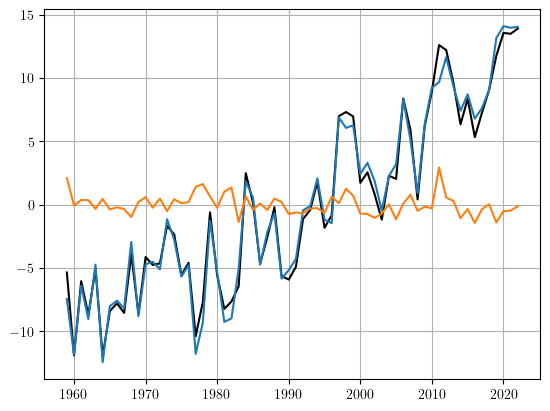

In [44]:
#double check
tgid='12'
plt.plot(tg_ann[tgid],'k')
plt.plot(tg_ibcorr[tgid])
plt.plot(tg_ib[tgid]) 
plt.grid()

In [45]:
# # convert to xarray
xr_tg=xr.DataArray(tg_ann)
xr_tg.name = 'TG_IB_CORR'
xr_tg=xr_tg.rename({'dim_1': 'tgindex'})
xr_tg=xr_tg.rename({'datetime': 'time'})
xr_tg = xr_tg.to_dataset()
dumvar=xr_tg.TG_IB_CORR[10,:]*0+1
varadd=dumvar*tgs_in.lat.values
xr_tg = xr_tg.assign(latitude=varadd)
varadd=dumvar*tgs_in.lon.values
da_tg = xr_tg.assign(longitude=varadd)
# da_tg=xr_tg.dropna(dim="tgindex", how="any")
tgnames=tgs_in.name2[xr_tg.tgindex.values]

In [46]:
gmsl = xr.open_dataset("../NSF-OCE_2148596/notebooks/global_timeseries_measures.nc.nc4")
gmsl = gmsl.sel(time=slice("1958-01-01", "2019-01-01"))  # .rename({'year':'time'})
gmsl_df1 = gmsl.global_average_sea_level_change.to_pandas() / 10
gmsl_df1.index = da_tg.time[:-3]
gmsl_df1 = gmsl_df1.to_frame()
gmsl_df1.columns = ["GMSL"]

gmsl = xr.open_dataset("../NSF-OCE_2148596/notebooks/SEUS_resolution_comparison/gmsl_mo.nc")
gmsl_df2 = gmsl.to_pandas() / 10
gmsl_df2 = gmsl_df2.resample("Y").agg(pd.Series.mean, skipna=True)
gmsl_df2 = gmsl_df2["2018-01-01":"2022-1-1"]
gmsl_df2.index = da_tg.time[-4:]
gmsl_df2.columns = ["GMSL"]
gmsl_df_ext = gmsl_df2[1::] + gmsl_df1.iloc[-1] - gmsl_df2.iloc[0]
gmsl_merged = pd.concat([gmsl_df1, gmsl_df_ext])

/glade/derecho/scratch/clittle/tmp/ipykernel_111915/755893827.py:10: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  gmsl_df2 = gmsl_df2.resample("Y").agg(pd.Series.mean, skipna=True)


In [47]:
da_tg = da_tg.TG_IB_CORR-gmsl_merged.to_numpy() # if gm removal
def detrend_linear_tg(da, dim):
    """ linear detrend DataArray along the axis dim """
    params = da.polyfit(dim=dim, deg=1)
    fit = xr.polyval(da[dim], params.polyfit_coefficients)
    da = da-fit
    return da, params.polyfit_coefficients[0,:]
    
da_tg,dd=detrend_linear_tg(da_tg,'time')

/glade/derecho/scratch/clittle/tmp/ipykernel_111915/3015224509.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = shortname[np.arange(0, len(tgnames), ylabspacing)]


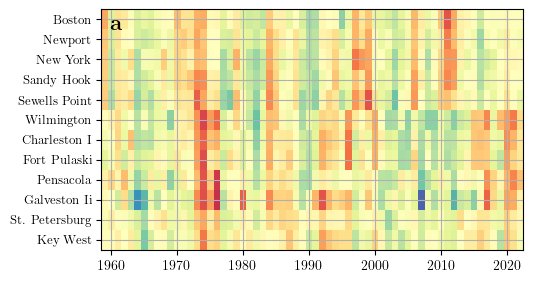

In [48]:
##TG corrections plot
fig = plt.figure(figsize=(14,10))#, tight_layout=True)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

nsim=1
cmap = mycolors.blue2red_cmap(20)
cmap='Spectral_r'
ylabspacing = 1

vmin = -12
vmax2 = -vmin
dain_obs=da_tg

for nsim in np.arange(1):
    if nsim<1:
        plotvar=dain_obs
    else:
        if nsim<2:
            plotvar=tg_ibcorr_det
        else:
            plotvar=tg_ibcorr_desea

    ax1 = plt.subplot2grid((3,5), (nsim, 1), colspan=2, rowspan=1)

    filled1 = ax1.pcolormesh(
        xr_tg.time,
        np.arange(0, len(tgnames), 1),
        plotvar.T,
        vmin=vmin,
        vmax=vmax2,
        cmap=cmap,
        shading="nearest",
    )
    plt.figtext(0.02, .9, r"$\bf{" + panellabs[nsim] + '' "}$" , horizontalalignment='left', 
                    verticalalignment='bottom', fontsize=16, transform=ax1.transAxes)
    # ticks = np.arange(1.5, len(tgnames)+.5, ylabspacing)
# labels = tgnames[np.arange(1, len(tgnames), ylabspacing)]
# ax2.yaxis.set_ticks(ticks, labels=labels)    # plt.xlim([1000,1060])
    ticks = np.arange(0, len(tgnames), ylabspacing)
    if nsim<5:
        labels = shortname[np.arange(0, len(tgnames), ylabspacing)]
    else:
        labels = []
    ax1.yaxis.set_ticks(ticks, labels=labels, fontsize=9)
    plt.ylim([-.5, len(tgnames)-.5])
    plt.grid()
    pos = ax1.get_position()  # get the original position
    
    if nsim>1:
        cbar_ax = fig.add_axes(
            [pos.x0, pos.y0-(pos.y1 - pos.y0)/4, (pos.x1-pos.x0), (pos.y1 - pos.y0)/20]
        )
        cbar = fig.colorbar(filled1, orientation="horizontal", cax=cbar_ax, extend="both",ticklocation='bottom')
        cbar.ax.set_title("Sea level anomaly (cm)", rotation=0, size=10, weight="bold")
        cbar.ax.tick_params(labelsize=10)
plt.savefig('s2.png',
)

/glade/derecho/scratch/clittle/tmp/ipykernel_111915/3015224509.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = shortname[np.arange(0, len(tgnames), ylabspacing)]


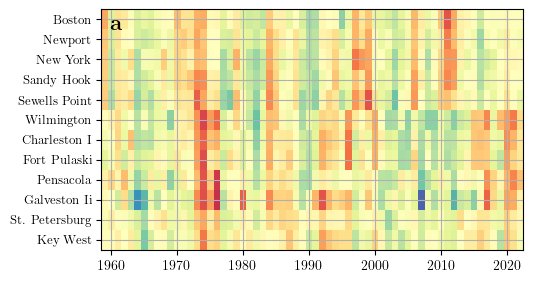

In [50]:
##TG corrections plot
fig = plt.figure(figsize=(14,10))#, tight_layout=True)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

nsim=1
cmap = mycolors.blue2red_cmap(20)
cmap='Spectral_r'
ylabspacing = 1

vmin = -12
vmax2 = -vmin
dain_obs=da_tg

for nsim in np.arange(1):
    if nsim<1:
        plotvar=dain_obs
    else:
        if nsim<2:
            plotvar=tg_ibcorr_det
        else:
            plotvar=tg_ibcorr_desea

    ax1 = plt.subplot2grid((3,5), (nsim, 1), colspan=2, rowspan=1)

    filled1 = ax1.pcolormesh(
        xr_tg.time,
        np.arange(0, len(tgnames), 1),
        plotvar.T,
        vmin=vmin,
        vmax=vmax2,
        cmap=cmap,
        shading="nearest",
    )
    plt.figtext(0.02, .9, r"$\bf{" + panellabs[nsim] + '' "}$" , horizontalalignment='left', 
                    verticalalignment='bottom', fontsize=16, transform=ax1.transAxes)
    # ticks = np.arange(1.5, len(tgnames)+.5, ylabspacing)
# labels = tgnames[np.arange(1, len(tgnames), ylabspacing)]
# ax2.yaxis.set_ticks(ticks, labels=labels)    # plt.xlim([1000,1060])
    ticks = np.arange(0, len(tgnames), ylabspacing)
    if nsim<5:
        labels = shortname[np.arange(0, len(tgnames), ylabspacing)]
    else:
        labels = []
    ax1.yaxis.set_ticks(ticks, labels=labels, fontsize=9)
    plt.ylim([-.5, len(tgnames)-.5])
    plt.grid()
    pos = ax1.get_position()  # get the original position
    
    if nsim>1:
        cbar_ax = fig.add_axes(
            [pos.x0, pos.y0-(pos.y1 - pos.y0)/4, (pos.x1-pos.x0), (pos.y1 - pos.y0)/20]
        )
        cbar = fig.colorbar(filled1, orientation="horizontal", cax=cbar_ax, extend="both",ticklocation='bottom')
        cbar.ax.set_title("Sea level anomaly (cm)", rotation=0, size=10, weight="bold")
        cbar.ax.tick_params(labelsize=10)
plt.savefig('s2.png',
)

In [46]:
tgs_in.to_pickle("tgs_in2.pkl")
tgs_in.to_csv("tgs_in2.csv",index=False)

In [ ]:
#processing functions

def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    # print(x)

    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)
    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
        
    # print(x)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    # print(x,y)
    n     = x.shape[0]
    xmean = x.mean(axis=0, skipna=False)
    ymean = y.mean(axis=0, skipna=False)
    xstd  = x.std(axis=0, skipna=False)
    ystd  = y.std(axis=0, skipna=False)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  
    
    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    # pval   = t.sf(tstats, n-2)*2
    pval = t.sf(abs(tstats), n-2)*2 #corrected
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov,cor,slope,intercept,pval,stderr

##   extract coastal points in model simulations for comparison with TGs

In [91]:
hr_tg=xr.open_dataset('/glade/work/clittle/p2679/alpaca_hr_tg_ssh_long.nc') 
hr_tg=hr_tg.ssh
hr_tg['time']=da_tg.time
lr_tg=xr.open_dataset('/glade/work/clittle/p2679/alpaca_lr_tg_ssh_long.nc') 
lr_tg=lr_tg.ssh
lr_tg['time']=da_tg.time

In [86]:
order = 5
fs = 1       # sample rate, yr-1
cutoff = 1/13 # desired cutoff frequency of the filter, yr-1

In [87]:
def butter_bpfilt_low(x,filt_year1,filt_year2,fs,order_butter):
    fc1 = filt_year1 # cut off frequency 1sample/ 1year = (1/1)/2 equals 1 year filter (two half cycles/sample)
    fc2 = filt_year2 # cut off frequency 1sample/ 1year = (1/1)/2 equals 1 year filter (two half cycles/sample)
    b, a = signal.butter(order_butter, [fc1], fs=fs, btype='low')
    return signal.filtfilt(b, a, x)
    
def filtfilt_bpbutter_2d_low(x,filt_year1,filt_year2,fs,order_butter,dim='time'):
    # x ...... xr data array
    # dims .... dimension aong which to apply function   
    filt= xr.apply_ufunc(
        butter_bpfilt_low,  # first the function
        x,# now arguments in the order expected by 'butter_filt'
        filt_year1,  # as above
        filt_year2,  # as above
        fs,  # as above
        order_butter,  # as above
       
        input_core_dims=[["tgindex","time"], [], [], [], []],  # regrid
        output_core_dims=[["tgindex","time"]],  # returned data has 3 dimension
        # exclude_dims=set(("time",)),  # dimensions allowed to change size. Must be a set!
        vectorize=True,  # loop over non-core dims
    )
    return filt

In [98]:
xr_tg.tgindex[5:]

<xarray.DataArray 'tgindex' (tgindex: 4)> Size: 32B
array(['366', '12', '351', '235'], dtype=object)
Coordinates:
  * tgindex  (tgindex) object 32B '366' '12' '351' '235'

In [157]:
hr_tg_lp=filtfilt_bpbutter_2d_low(hr_tg,cutoff,cutoff,fs,order,dim='time')
lr_tg_lp=filtfilt_bpbutter_2d_low(lr_tg,cutoff,cutoff,fs,order,dim='time')
xr_tg_lp=filtfilt_bpbutter_2d_low(xr_tg.TG_IB_CORR,cutoff,cutoff,fs,order,dim='time')
# xr_tg_lp=filtfilt_bpbutter_2d_low(xr_tg.TG_IB_CORR,cutoff,cutoff,fs,order,dim='time')

/glade/derecho/scratch/clittle/tmp/ipykernel_97477/1883613384.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = shortname[np.arange(0, len(tgnames), ylabspacing)]


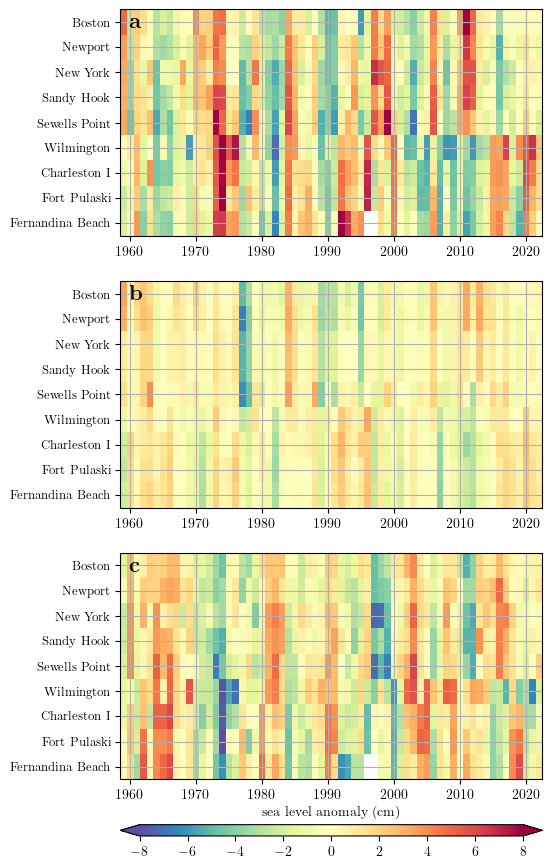

In [95]:
fig = plt.figure(figsize=(14,10))#, tight_layout=True)
plt.subplots_adjust(wspace=0.1, hspace=0.2)

nsim=1
cmap = mycolors.blue2red_cmap(20)
cmap='Spectral_r'
ylabspacing = 1

vmin = -8
vmax2 = -vmin

for nsim in np.arange(3):
    if nsim<1:
        plotvar=da_tg
    else:
        if nsim<2:
            plotvar=lr_tg.T
        else:
            plotvar=lr_tg.T-da_tg

    ax1 = plt.subplot2grid((3,5), (nsim, 1), colspan=2, rowspan=1)

    filled1 = ax1.pcolormesh(
        lr_tg.time,
        np.arange(0, len(tgnames), 1),
        plotvar.T,
        vmin=vmin,
        vmax=vmax2,
        cmap=cmap,
        shading="nearest",
    )
    plt.figtext(0.02, .9, r"$\bf{" + panellabs[nsim] + '' "}$" , horizontalalignment='left', 
                    verticalalignment='bottom', fontsize=16, transform=ax1.transAxes)
    # ticks = np.arange(1.5, len(tgnames)+.5, ylabspacing)
# labels = tgnames[np.arange(1, len(tgnames), ylabspacing)]
# ax2.yaxis.set_ticks(ticks, labels=labels)    # plt.xlim([1000,1060])
    ticks = np.arange(0, len(tgnames), ylabspacing)
    if nsim<5:
        labels = shortname[np.arange(0, len(tgnames), ylabspacing)]
    else:
        labels = []
    ax1.yaxis.set_ticks(ticks, labels=labels, fontsize=9)
    plt.ylim([-.5, len(tgnames)-.5])
    plt.grid()
    pos = ax1.get_position()  # get the original position
    
    if nsim>1:
        cbar_ax = fig.add_axes(
            [pos.x0, pos.y0-(pos.y1 - pos.y0)/4, (pos.x1-pos.x0), (pos.y1 - pos.y0)/20]
        )
        cbar = fig.colorbar(filled1, orientation="horizontal", cax=cbar_ax, extend="both",ticklocation='bottom')
        cbar.ax.set_title("sea level anomaly (cm)", rotation=0, size=10, weight="bold")
        cbar.ax.tick_params(labelsize=10)
plt.savefig('HRvTG.png',
)

In [50]:
# lr_tg_lp=lr_tg_lp.sel(time=slice("2002-01-01","2025-01-01"))
# hr_tg_lp=hr_tg_lp.sel(time=slice("2002-01-01","2025-01-01"))
lr_tg=lr_tg.sel(time=slice("2002-01-01","2025-01-01"))
hr_tg=hr_tg.sel(time=slice("2002-01-01","2025-01-01"))
xr_tg=xr_tg.TG_IB_CORR.sel(time=slice("2002-01-01","2025-01-01"))

hr_tg,dd=detrend_linear_tg(hr_tg,'time')

/glade/derecho/scratch/clittle/tmp/ipykernel_97477/2349557215.py:26: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend([],     # The line objects


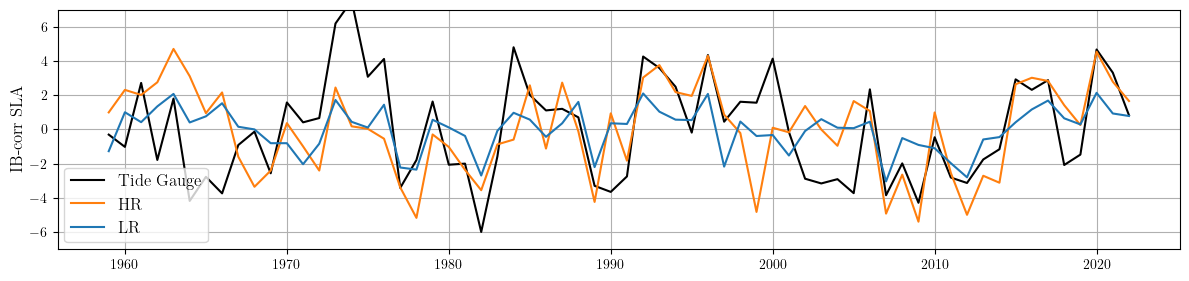

In [105]:
fig = plt.figure(figsize=(12,8), tight_layout=True)
cmap = mycolors.blue2red_cmap(20)

ax = plt.subplot2grid((3,3), (2,0), colspan=3, rowspan=1)    
# for nsim in np.arange(1):
    
# line = ax.plot(xr_tg.time,xr_tg_lp.sel(tgindex=focustg),cols[0], label = 'data')
# line = ax.plot(lr_tg_lp.time,hr_tg_lp.mean(dim='tgindex'),cols[1], label = 'data')
# line = ax.plot(lr_tg_lp.time,lr_tg_lp.mean(dim='tgindex'),cols[2], label = 'data')
line = ax.plot(da_tg.time,da_tg.isel(tgindex=slice(5,)).mean(dim='tgindex'),cols[0], label = 'data')
line = ax.plot(lr_tg.time,hr_tg.isel(tgindex=slice(5,)).mean(dim='tgindex'),cols[1], label = 'data')
line = ax.plot(lr_tg.time,lr_tg.isel(tgindex=slice(5,)).mean(dim='tgindex'),cols[2], label = 'data')
# line = ax.plot(lr_tg_lp.time,lr_tg.mean(dim='tgindex'),cols[2], label = 'data')
# line = ax.plot(xr_tg.time,xr_tg_lp.mean(dim='tgindex'),cols[0], label = 'data')
    # if nsim>0:
    #     tt=-np.corrcoef(tgpcs[nsim][nmode,:],tgpcs[0][nmode,:])
    #     if nsim<2:
    #         ax.text(.25,.83, '$r=$'+str('{0:.2f}'.format(tt[0,1])),#+', ',
    #             transform=ax.transAxes, fontsize=14, weight='bold',color='C1')
    #     else:
    #         ax.text(.25,.73, '$r=$'+str('{0:.2f}'.format(tt[0,1])),#+', ',
    #             transform=ax.transAxes, fontsize=14, weight='bold',color='C0') 
plt.ylim(-7,7)
plt.grid()
plt.ylabel('IB-corr SLA',fontsize=12)
ax.legend([],     # The line objects
       labels=["Tide Gauge", "HR", "LR"],   # The labels for each line
       loc="lower left",   # Position of legend
       borderaxespad=0.4,    # Small spacing around legend box
       title="",
       fontsize=12,# Title for the legend
       )
plt.savefig('CESMvTG_long.png',
)

In [ ]:
xr_tg.time,xr_tg.sel(tgindex=focustg)

## tide gauge EOFs

In [51]:
#winter months only -- annual
def djf_mean(da):
    # mask other months with nan
    da_DJF = da.where(da['time.season'] == 'DJF')
    # rolling mean -> only Jan is not nan
    # however, we loose Jan/ Feb in the first year and Dec in the last
    da_DJF = da_DJF.rolling(min_periods=3, center=True, time=3).mean()
    # make annual mean
    return da_DJF.groupby('time.year').mean('time').rename({'year':'time'}).dropna('time', how='all')

In [60]:
# !pip install -U xeofs

In [61]:
kwargs = dict(n_modes=len(xr_tg.TG_IB_CORR.T)-1,random_state=2)#, normalize=True)
expvars=[]
pcs=[]
amps=[]
phases=[]
recs_m1=[]
recs_m2=[]
recs_m3=[]
recs_tot=[]
real_ts=[]
djf_flag=True
djf_flag=False

for nsim in np.arange(1):
    if nsim<1:
        dain=da_tg#xr_tg.TG_IB_CORR+xr_tg.TG_IB_CORR*0
    else:
        if nsim<2:
            dain=hr_tg.T+xr_tg.TG_IB_CORR*0
        else:
            dain=lr_tg.T+xr_tg.TG_IB_CORR*0
            
    if djf_flag:
        dain=djf_mean(dain)
    
    # model = xeofs.models.ComplexEOF(padding="none", **kwargs)
    # model = xeofs.models.EOF(**kwargs)
    model = xeofs.single.EOF(**kwargs)
    model.fit(dain, dim=("time"))
    expvar = model.explained_variance()
    expvar_ratio = model.explained_variance_ratio()
    amp = model.components()
    phase = amp
    # amp = model.components_amplitude()
    # phase = model.components_phase()
    phase = phase-phase.sel(tgindex='351')
    scores = model.scores(normalized=True)
    
    expvars.append(expvar_ratio)
    real_ts.append(dain)
    pcs.append(scores)
    amps.append(amp)
    phases.append(phase)
    
    rec=model.inverse_transform(scores[0,:],normalized=True)
    recs_m1.append(rec)
    rec=model.inverse_transform(scores[1,:],normalized=True)
    recs_m2.append(rec)
    rec=model.inverse_transform(scores[2,:],normalized=True)
    recs_m3.append(rec)
    rec=model.inverse_transform(scores,normalized=True)
    recs_tot.append(rec)
    if nsim<1:
        tgout=dain

In [62]:
for nsim in np.arange(len(pcs)): 
    # total_var=real_ts[nsim].var(dim='time')
    norm_fac=np.real(pcs[nsim]).std(dim='time')
    pcs[nsim]=np.real(pcs[nsim])/norm_fac
    amps[nsim]=np.real(amps[nsim])/norm_fac

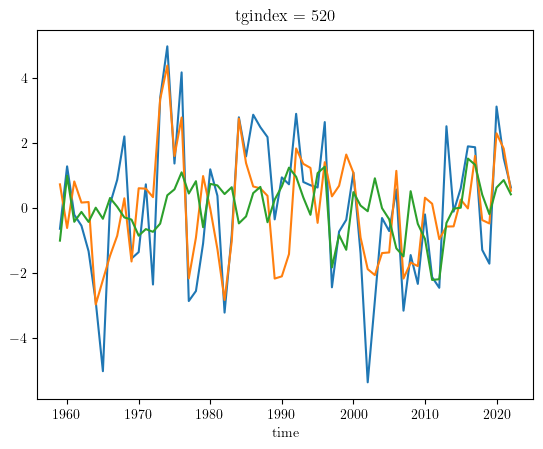

In [63]:
ntg=1
nsim=0
# recs_m1[0][:,4].plot()
# recs_m2[0][:,4].plot()
# recs_m3=recs_m1+recs_m2
real_ts[nsim][:,ntg].plot()
recs_m1[nsim][:,ntg].plot()
# recs_m2[nsim][:,ntg].plot()
recs_m2[nsim][:,ntg].plot()
# recs_tot[nsim][:,ntg].plot()
# (recs_m1[nsim][:,ntg]+recs_m2[nsim][:,ntg]+recs_m3[nsim][:,ntg]).plot()

In [64]:
expvars[0].values,expvars[1].values,expvars[2].values

IndexError: list index out of range

In [65]:
rotated_crs = xccrs.RotatedPole(pole_longitude=25.0, pole_latitude=70.0) # define projection!
varscale=300
vmaxin=7

In [70]:
def plot_obs_pcs(tgpcs,vmaxin, varscale):
    fig = plt.figure(figsize=(10,13))#, tight_layout=True)
    plt.subplots_adjust(wspace=0.1, hspace=0.2)

    nsim=0
    cmap = 'plasma'
    cmap = mycolors.blue2red_cmap(20)
    tot_var=recs_tot[nsim].var(dim='time')    

    ylabspacing = 2
    
    vmin = -12
    vmax2 = -vmin

    # ax1 = plt.subplot2grid((5,3), (1, 1), colspan=2, rowspan=1)
    # # titstr = "Annual mean TG sea level 1950-2022"
    # # ax2 = ax1.twinx()
    # da_tg=xr_tg.TG_IB_CORR+xr_tg.TG_IB_CORR*0
    
    # filled1 = ax1.pcolormesh(
    #     da_tg.time,
    #     np.arange(0, len(tgnames), 1),
    #     da_tg.T,
    #     vmin=vmin,
    #     vmax=vmax2,
    #     cmap=cmap,
    #     shading="nearest",
    # )
    # plt.ylim([0, len(tgnames)])
    
    # ticks = np.arange(0, len(tgnames), ylabspacing)
    # labels = tgnames[np.arange(0, len(tgnames), ylabspacing)]
    # ax1.yaxis.set_ticks(ticks, labels=labels, fontsize=9)
    # # ticks = np.arange(1.5, len(tgnames)+.5, ylabspacing)
    # # labels = tgnames[np.arange(1, len(tgnames), ylabspacing)]
    # # ax2.yaxis.set_ticks(ticks, labels=labels)

    # plt.figtext(0.02, .9, r"$\bf{" + panellabs[0] + '' "}$", horizontalalignment='left', 
    #                 verticalalignment='bottom', fontsize=16, transform=ax1.transAxes)
    # plt.grid()
    # # ax1.set_title(titstr, loc="center", fontsize=12)
    
    # pos = ax1.get_position()  # get the original position
    
    # cbar_ax = fig.add_axes(
    #     [pos.x1+(pos.x1 - pos.x0) / 40, pos.y0, (pos.x1 - pos.x0) / 40,(pos.y1 - pos.y0)]
    # )
    # cbar = fig.colorbar(filled1, orientation="vertical", cax=cbar_ax, extend="both",ticklocation='right')
    # # cbar.ax.set_title("Detrended/deseasonalized TG sea level", rotation=0, size=10, weight="bold")
    # cbar.ax.tick_params(labelsize=10)

    for nmode in np.arange(3):
        ax = plt.subplot2grid((5,3), (2, nmode), colspan=1, rowspan=2, projection=rotated_crs)#, aspect="auto")
        pos = ax.get_position() # get the original position 
        vmin=-vmaxin
        vmax=-vmin

        if nmode<1:    
            VE=recs_m1[nsim].var(dim='time')/tot_var
        else:
            if nmode<2:    
                VE=recs_m2[nsim].var(dim='time')/tot_var
            else:
                VE=recs_m3[nsim].var(dim='time')/tot_var
        
        filled1 = plt.scatter(
            x=tgs_in.lon,
            y=tgs_in.lat,
            vmin=vmin,
            vmax=vmax,
            c=amps[nsim][nmode,:],
            cmap=cmap,  # this is the changes
            s=varscale,#*VE**2,
            alpha=1,
            edgecolors="k",
            linewidth=1,
            # marker=None,
            zorder=7,
            transform=xccrs.PlateCarree(),
        )  ## Important
        
        for nkey in np.arange(2):
            varval=varscale*(.25+.5*nkey)**2
            
            varkey = plt.scatter(
                x=tgs_in.lon,
                y=tgs_in.lat,
                vmin=vmin,
                vmax=vmax,
                c=amps[nsim][nmode,:],
                cmap=cmap,  # this is the changes
                s=varval,
                alpha=1,
                edgecolors=".6",
                linewidth=1,
                # marker=None,
                zorder=7,
                transform=xccrs.PlateCarree(),
            )  ## Important
            
            varkey.set_facecolor("none")   

        ax.set_extent([-74, -78, 20, 48], crs=xccrs.PlateCarree())        
        ax.add_feature(cfeature.LAND.with_scale('110m'),zorder=2,color='.9')
        ax.add_feature(cfeature.STATES, edgecolor='k',zorder=3)
        ax.add_feature(cfeature.LAKES,zorder=3)

        ax.coastlines(zorder=5)
        ax.gridlines()

        if nmode<1:
            cbar_ax = fig.add_axes(
                [pos.x1-(pos.x1 - pos.x0)/4, pos.y0+(pos.y1 - pos.y0)/4, (pos.x1 - pos.x0)/25, (pos.y1 - pos.y0)/2]
            )
            cbar = fig.colorbar(filled1, orientation="vertical", cax=cbar_ax, extend="both",ticklocation='left')
            cbar.ax.set_title("EOF (cm/SD)", rotation=0, size=10, weight="bold")
            cbar.ax.tick_params(labelsize=10)
                
        # ax.text(.02,.95, 'PC' + str(nsp+1) + ' lags by ' + str(lagx) + ' months' , transform=ax.transAxes, fontsize=12, weight='bold')
        # plt.figtext(-110,-40, "LF VE. = {:.0}".format(VE[nsp]), horizontalalignment='right', verticalalignment='center', fontsize=16, transform=ax.transAxes)
        # plt.figtext(0.02, .95, r"$\bf{" + panellabs[nmode] + '' "}$" + 'EOF'+str(nmode+1), horizontalalignment='left', 
        plt.figtext(0.02, .95, r"$\bf{" + panellabs[nmode] + '' "}$" + '', horizontalalignment='left', 
                    verticalalignment='bottom', fontsize=12, transform=ax.transAxes)
        plt.figtext(0.02, .04, ''+'{0:.0f}'.format(expvars[nsim][nmode].values*100)+"\%", horizontalalignment='left', 
                verticalalignment='bottom', fontsize=12, transform=ax.transAxes)
    import matplotlib.dates as mdates
    ax = plt.subplot2grid((5,3), (4,0), colspan=3, rowspan=1)    
    for nsp in np.arange(2):
        line = ax.plot(pcs[nsim].time,pcs[nsim][nsp,:],cols[nsp], label = 'data')
    # years = mdates.YearLocator()   # every year
    # years_fmt = mdates.DateFormatter('%Y')
    # ax.xaxis.set_major_locator(years)
    # ax.xaxis.set_major_formatter(years_fmt)
    plt.grid()
    plt.ylabel('Normalized PC')
    ax.legend([],     # The line objects
           labels=["TG PC1","TG PC2"],   # The labels for each line
           loc="upper right",   # Position of legend
           borderaxespad=0.4,    # Small spacing around legend box
           title="",
           fontsize=12,# Title for the legend
             )
    plt.figtext(0.02, .86, r"$\bf{" + panellabs[3] + '' "}$", horizontalalignment='left', 
                    verticalalignment='bottom', fontsize=12, transform=ax.transAxes)



/glade/derecho/scratch/clittle/tmp/ipykernel_111915/1141344303.py:136: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend([],     # The line objects


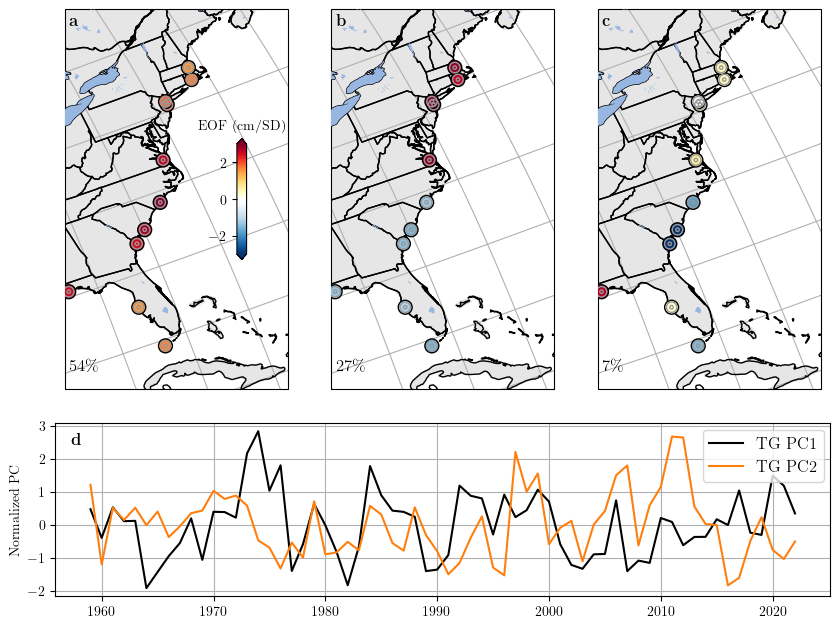

In [72]:
plot_obs_pcs(pcs[0],3, 100)#amps[nsim][0:2,:].max())
plt.savefig('s4.png',
)

## comp with FOSIS

In [49]:
def plot_fosi_pcs(tgpcs,amps,recs_mode,nmode,vmaxin,varscale):
    fig = plt.figure(figsize=(10,8), tight_layout=True)
    cmap = mycolors.blue2red_cmap(20)
    
    for nsim in np.arange(3):
        ax = plt.subplot2grid((3,3), (0, nsim), colspan=1, rowspan=2, projection=rotated_crs, aspect="auto")
        pos = ax.get_position() # get the original position 
        vmax=vmaxin
        vmin=-vmax
        
        tot_var=recs_tot[nsim].var(dim='time')    
        VE=recs_mode[nsim].var(dim='time')/tot_var
        
        filled1 = plt.scatter(
            x=tgs_in.lon,
            y=tgs_in.lat,
            vmin=vmin,
            vmax=vmax,
            c=amps[nsim][nmode,:],
            cmap=cmap,  # this is the changes
            s=varscale*VE**2,
            alpha=1,
            edgecolors="k",
            linewidth=1,
            # marker=None,
            zorder=7,
            transform=xccrs.PlateCarree(),
        )  ## Important
        
        for nkey in np.arange(2):
            varval=varscale*(.25+.5*nkey)**2
            
            varkey = plt.scatter(
                x=tgs_in.lon,
                y=tgs_in.lat,
                vmin=vmin,
                vmax=vmax,
                c=amps[nsim][nmode,:],
                cmap=cmap,  # this is the changes
                s=varval,
                alpha=1,
                edgecolors=".6",
                linewidth=1,
                # marker=None,
                zorder=7,
                transform=xccrs.PlateCarree(),
            )  ## Important
            
            varkey.set_facecolor("none")   
            
        ax.set_extent([-74, -78, 20, 48], crs=xccrs.PlateCarree())       
        ax.set_extent([-74, -78, 21, 47], crs=xccrs.PlateCarree())       
        ax.add_feature(cfeature.LAND.with_scale('110m'),zorder=2,color='.9')
        ax.add_feature(cfeature.STATES, edgecolor='k',zorder=3)
        ax.add_feature(cfeature.LAKES,zorder=3)

        ax.coastlines(zorder=5)
        ax.gridlines()

        if nsim<1:
            cbar_ax = fig.add_axes(
                [pos.x1-(pos.x1 - pos.x0)/3.5, pos.y0+(pos.y1 - pos.y0)/4, (pos.x1 - pos.x0)/25, (pos.y1 - pos.y0)/1.75]
            )
            cbar = fig.colorbar(filled1, orientation="vertical", cax=cbar_ax, extend="both",ticklocation='left')
            cbar.ax.set_title("EOF amplitude", rotation=0, size=12, weight="bold")
            cbar.ax.tick_params(labelsize=10)
        if nsim<1:    
            plt.figtext(0.02, .95, r"$\bf{" + panellabs[nsim] + '' "}$" + '', horizontalalignment='left', verticalalignment='bottom', fontsize=14, transform=ax.transAxes)
            plt.figtext(0.02, .1, 'Tide Gauge', horizontalalignment='left', verticalalignment='bottom', fontsize=14, transform=ax.transAxes)
        else:
            if nsim<2:    
                plt.figtext(0.02, .1, 'HR', horizontalalignment='left', verticalalignment='bottom', fontsize=14, transform=ax.transAxes)
                plt.figtext(0.02, .95, r"$\bf{" + panellabs[nsim] + '' "}$" + '', horizontalalignment='left', verticalalignment='bottom', fontsize=14, transform=ax.transAxes)
            else:
                plt.figtext(0.02, .1, 'LR', horizontalalignment='left', verticalalignment='bottom', fontsize=14, transform=ax.transAxes)
                plt.figtext(0.02, .95, r"$\bf{" + panellabs[nsim] + '' "}$" + '', horizontalalignment='left', verticalalignment='bottom', fontsize=14, transform=ax.transAxes)
                
        plt.figtext(0.02, .04, ''+'{0:.0f}'.format(expvars[nsim][nmode].values*100)+"\%", horizontalalignment='left', 
                verticalalignment='bottom', fontsize=14, transform=ax.transAxes)
# ax1.text(.02,.92, r"$\bf{" + panellabs[0] + "}$", transform=ax1.transAxes, fontsize=18, weight='bold')
        
    ax = plt.subplot2grid((3,3), (2,0), colspan=3, rowspan=1)    
    for nsim in np.arange(3):
        line = ax.plot(tgpcs[nsim].time,tgpcs[nsim][nmode,:],cols[nsim], label = 'data')
        if nsim>0:
            tt=np.corrcoef(tgpcs[nsim][nmode,:],tgpcs[0][nmode,:])
            if nsim<2:
                ax.text(.25,.83, '$r=$'+str('{0:.2f}'.format(tt[0,1])),#+', ',
                    transform=ax.transAxes, fontsize=14, weight='bold',color='C1')
            else:
                ax.text(.25,.73, '$r=$'+str('{0:.2f}'.format(tt[0,1])),#+', ',
                    transform=ax.transAxes, fontsize=14, weight='bold',color='C0') 
    plt.ylim(-5,5)
    plt.grid()
    plt.ylabel('Normalized PC1',fontsize=12)
    ax.legend([],     # The line objects
           labels=["Tide Gauge", "HR", "LR"],   # The labels for each line
           loc="lower left",   # Position of legend
           borderaxespad=0.4,    # Small spacing around legend box
           title="",
           fontsize=12,# Title for the legend
           )

In [50]:
def plot_fosi_pcs_m2(tgpcs,amps,recs_mode,nmode,vmaxin,varscale):
    fig = plt.figure(figsize=(10,8), tight_layout=True)
    cmap = mycolors.blue2red_cmap(20)
    
    for nsim in np.arange(3):
        ax = plt.subplot2grid((3,3), (0, nsim), colspan=1, rowspan=2, projection=rotated_crs, aspect="auto")
        pos = ax.get_position() # get the original position 
        vmax=vmaxin
        vmin=-vmax
        
        tot_var=recs_tot[nsim].var(dim='time')    
        VE=recs_mode[nsim].var(dim='time')/tot_var

        if nsim<1:
            factor=-1
        else:
            factor=1
            
        filled1 = plt.scatter(
            x=tgs_in.lon,
            y=tgs_in.lat,
            vmin=vmin,
            vmax=vmax,
            c=factor*amps[nsim][nmode,:],
            cmap=cmap,  # this is the changes
            s=varscale*VE**2,
            alpha=1,
            edgecolors="k",
            linewidth=1,
            # marker=None,
            zorder=7,
            transform=xccrs.PlateCarree(),
        )  ## Important
        
        for nkey in np.arange(2):
            varval=varscale*(.25+.5*nkey)**2
            
            varkey = plt.scatter(
                x=tgs_in.lon,
                y=tgs_in.lat,
                vmin=vmin,
                vmax=vmax,
                c=factor*amps[nsim][nmode,:],
                cmap=cmap,  # this is the changes
                s=varval,
                alpha=1,
                edgecolors=".6",
                linewidth=1,
                # marker=None,
                zorder=7,
                transform=xccrs.PlateCarree(),
            )  ## Important
            
            varkey.set_facecolor("none")   
            
        ax.set_extent([-74, -78, 20, 48], crs=xccrs.PlateCarree())       
        ax.set_extent([-74, -78, 21, 47], crs=xccrs.PlateCarree())       
        ax.add_feature(cfeature.LAND.with_scale('110m'),zorder=2,color='.9')
        ax.add_feature(cfeature.STATES, edgecolor='k',zorder=3)
        ax.add_feature(cfeature.LAKES,zorder=3)

        ax.coastlines(zorder=5)
        ax.gridlines()

        if nsim<1:
            cbar_ax = fig.add_axes(
                [pos.x1-(pos.x1 - pos.x0)/3.5, pos.y0+(pos.y1 - pos.y0)/4, (pos.x1 - pos.x0)/25, (pos.y1 - pos.y0)/1.75]
            )
            cbar = fig.colorbar(filled1, orientation="vertical", cax=cbar_ax, extend="both",ticklocation='left')
            cbar.ax.set_title("EOF amplitude", rotation=0, size=12, weight="bold")
            cbar.ax.tick_params(labelsize=10)
        if nsim<1:    
            plt.figtext(0.02, .95, r"$\bf{" + panellabs[nsim] + '' "}$" + '', horizontalalignment='left', verticalalignment='bottom', fontsize=14, transform=ax.transAxes)
            plt.figtext(0.02, .1, 'Tide Gauge', horizontalalignment='left', verticalalignment='bottom', fontsize=14, transform=ax.transAxes)
        else:
            if nsim<2:    
                plt.figtext(0.02, .1, 'HR', horizontalalignment='left', verticalalignment='bottom', fontsize=14, transform=ax.transAxes)
                plt.figtext(0.02, .95, r"$\bf{" + panellabs[nsim] + '' "}$" + '', horizontalalignment='left', verticalalignment='bottom', fontsize=14, transform=ax.transAxes)
            else:
                plt.figtext(0.02, .1, 'LR', horizontalalignment='left', verticalalignment='bottom', fontsize=14, transform=ax.transAxes)
                plt.figtext(0.02, .95, r"$\bf{" + panellabs[nsim] + '' "}$" + '', horizontalalignment='left', verticalalignment='bottom', fontsize=14, transform=ax.transAxes)
                
        plt.figtext(0.02, .04, ''+'{0:.0f}'.format(expvars[nsim][nmode].values*100)+"\%", horizontalalignment='left', 
                verticalalignment='bottom', fontsize=14, transform=ax.transAxes)
# ax1.text(.02,.92, r"$\bf{" + panellabs[0] + "}$", transform=ax1.transAxes, fontsize=18, weight='bold')
        
    ax = plt.subplot2grid((3,3), (2,0), colspan=3, rowspan=1)    
    for nsim in np.arange(3):
        if nsim<1:
            factor=-1
        else:
            factor=1
        
        line = ax.plot(tgpcs[nsim].time,factor*tgpcs[nsim][nmode,:],cols[nsim], label = 'data')
        if nsim>0:
            tt=-np.corrcoef(tgpcs[nsim][nmode,:],tgpcs[0][nmode,:])
            if nsim<2:
                ax.text(.25,.83, '$r=$'+str('{0:.2f}'.format(tt[0,1])),#+', ',
                    transform=ax.transAxes, fontsize=14, weight='bold',color='C1')
            else:
                ax.text(.25,.73, '$r=$'+str('{0:.2f}'.format(tt[0,1])),#+', ',
                    transform=ax.transAxes, fontsize=14, weight='bold',color='C0') 
    plt.ylim(-5,5)
    plt.grid()
    plt.ylabel('Normalized PC1',fontsize=12)
    ax.legend([],     # The line objects
           labels=["Tide Gauge", "HR", "LR"],   # The labels for each line
           loc="lower left",   # Position of legend
           borderaxespad=0.4,    # Small spacing around legend box
           title="",
           fontsize=12,# Title for the legend
           )

/glade/derecho/scratch/clittle/tmp/ipykernel_119326/2670657562.py:96: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend([],     # The line objects
/glade/derecho/scratch/clittle/tmp/ipykernel_119326/4046336985.py:2: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('f1.png',
/glade/derecho/scratch/clittle/tmp/ipykernel_119326/4046336985.py:2: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('f1.png',
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


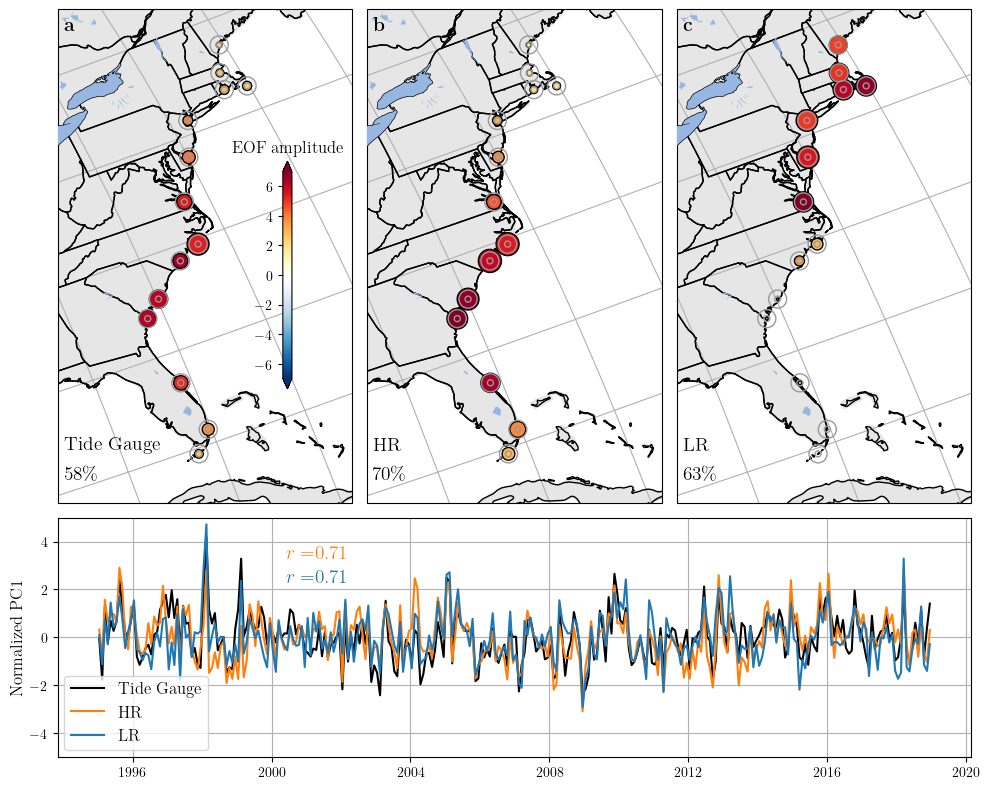

In [51]:
plot_fosi_pcs(pcs,amps,recs_m1,0,vmaxin,varscale)
plt.savefig('f1.png',
)

/glade/derecho/scratch/clittle/tmp/ipykernel_119326/2007499725.py:106: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend([],     # The line objects
/glade/derecho/scratch/clittle/tmp/ipykernel_119326/1055985823.py:3: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('s3.png',
/glade/derecho/scratch/clittle/tmp/ipykernel_119326/1055985823.py:3: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('s3.png',
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


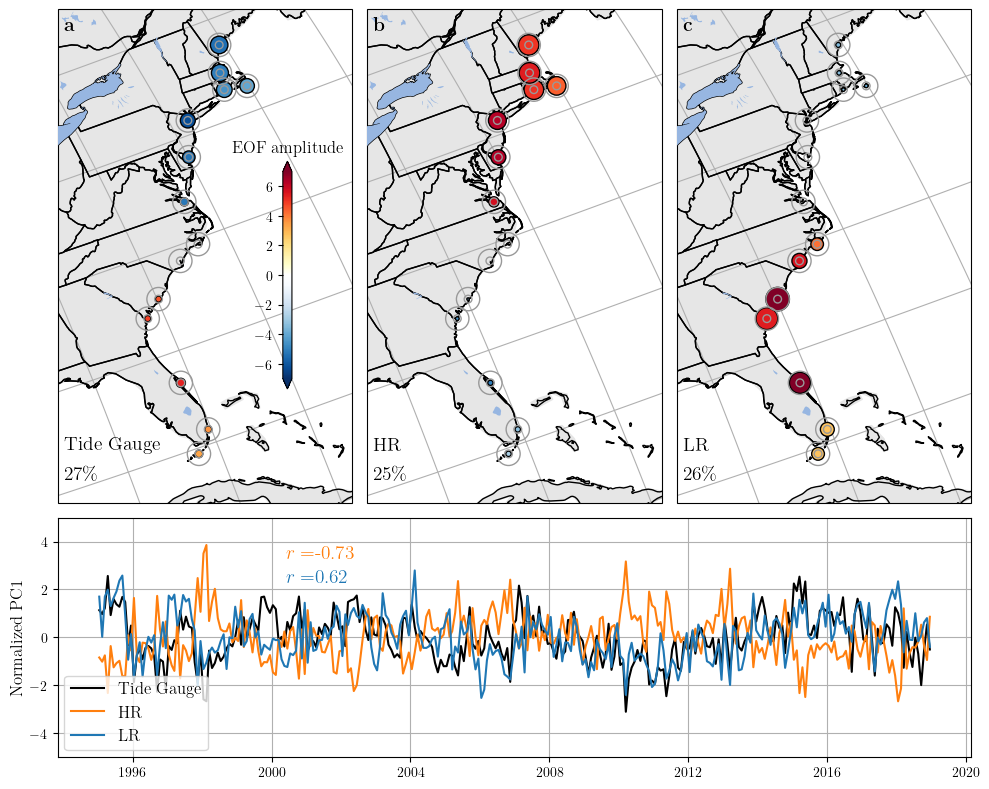

In [52]:
varscale=500
plot_fosi_pcs_m2(pcs,amps,recs_m2,1,vmaxin,varscale)
plt.savefig('s3.png',
)
varscale=300